In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates 
import re

# import statsmodels.formula.api as smf
import pyfixest as pf

pd.set_option('display.max_columns', 100)
style.use("fivethirtyeight")


# Prepare data

The code below is described in the presentation 
https://docs.google.com/presentation/d/1gO-mXl1RBJlqV3P5a3zqsUiYcnQn3FaBVou7awTAxz8/edit#slide=id.g2ef357d9a9f_0_0

All products/items from Prozorro in 2023-2024 in Prozorro on the 30190000-7 Office equipment market.

In 2023-2024, we had 518,601 price records for the office market. After cleaning missing values, 237,260 positions remained for 89,947 unique tenders/lots. 

In [109]:
df = pd.read_csv('./3019/dirty_prozorro_with_prices_cpv3019.csv',sep=';')
df = df[1:]
print(df.shape)
df = df[df['Початкова ціна за одиницю предмета лота (Валюта)']!='-']
df['date'] = pd.to_datetime(df['Дата'],format='%d.%m.%Y')
df['price'] = pd.to_numeric(df['Початкова ціна за одиницю предмета лота (Валюта)'].str.replace(',','.').str.replace(' ',''))
df['price_vat'] = df.apply(lambda x: x['price']*1.2 if x['Чи включено ПДВ у поточну ціну предмета лота']=='0' else x['price'],axis=1)
df = df[df['price']>0]
print(df.shape)
df = df.rename(columns={'Ідентифікатор лота':'lot_id','Назва предмета лота':'product_description_ukr'})
# df = df[:5000]
df

(518601, 10)
(253488, 13)


,lot_id,Клас CPV предмета лота,product_description_ukr,Початкова ціна за одиницю предмета лота (Валюта),Очікувана кількість одиниць предмета лота,Поточна ціна за одиницю предмета лота (Валюта),Чи включено ПДВ у поточну ціну предмета лота,Класифікація CPV предмета лота,Дата,Count([Ідентифікатор лота]),date,price,price_vat
1,UA-2022-02-23-011883-a-L1,30190000-7 Офісне устаткування та приладдя різне,канцелярські товари,"642,86",7,642.86,0,30197000-6 Дрібне канцелярське приладдя,04.03.2024,1,2024-03-04,642.86,771.432
2,UA-2022-03-10-000349-b-L1,30190000-7 Офісне устаткування та приладдя різне,"папір офісний А4, канцелярські товари (файли, ...",68,100,68,0,30190000-7 Офісне устаткування та приладдя різне,13.01.2023,1,2023-01-13,68.00,81.600
3,UA-2022-03-17-000847-b-L1,30190000-7 Офісне устаткування та приладдя різне,Папір для фотокопіювання та ксерографії,125,8,125,0,30197642-8 Папір для фотокопіювання та ксерогр...,16.02.2023,1,2023-02-16,125.00,150.000
4,UA-2022-04-01-000686-c-L1,30190000-7 Офісне устаткування та приладдя різне,ДК 021-2015:30190000-7 Офісне устаткування та ...,112.7,30,112.7,0,30190000-7 Офісне устаткування та приладдя різне,17.07.2023,1,2023-07-17,112.70,135.240
5,UA-2022-05-05-001087-a-L1,30190000-7 Офісне устаткування та приладдя різне,Скоби до степлера,12,2,12,0,30197110-0 Скоби,27.01.2023,1,2023-01-27,12.00,14.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
518594,UA-2024-07-26-009026-a-L1,30190000-7 Офісне устаткування та приладдя різне,Скріпки 28мм 100шт. круглі 5005 Buromax нікель,10.74,1.0,-,Не визначено,30197000-6 Дрібне канцелярське приладдя,26.07.2024,1,2024-07-26,10.74,10.740
518595,UA-2024-07-26-009028-a-L1,30190000-7 Офісне устаткування та приладдя різне,Біндер 25мм чорний Buromax BM.5304 12шт,"26,94",1.0,-,Не визначено,30197000-6 Дрібне канцелярське приладдя,26.07.2024,1,2024-07-26,26.94,26.940
518596,UA-2024-07-26-009029-a-L1,30190000-7 Офісне устаткування та приладдя різне,"Термоетикетка Еко 58х40/ 0,7тис з PriPrint",80.94,1.0,-,Не визначено,30199760-5 Етикетки,26.07.2024,1,2024-07-26,80.94,80.940
518597,UA-2024-07-26-009033-a-L1,30190000-7 Офісне устаткування та приладдя різне,Ручка кулькова з грипом 8100 Buromax чорна,7.18,1.0,-,Не визначено,30192121-5 Кулькові ручки,26.07.2024,1,2024-07-26,7.18,7.180


<Axes: xlabel='date', ylabel='# of purchase by months'>

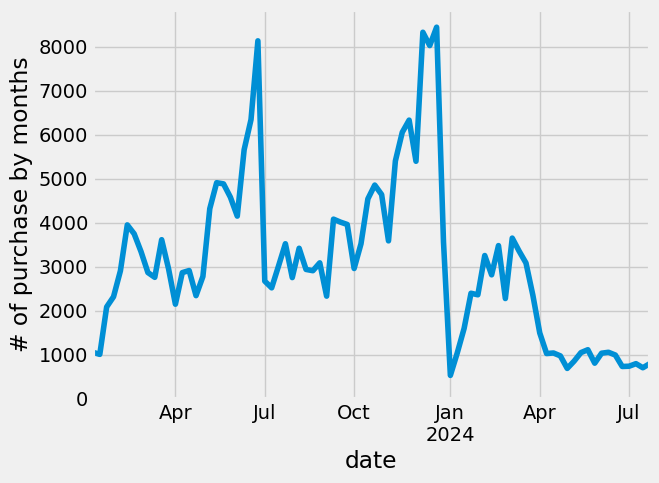

In [110]:
df.groupby([pd.Grouper(key='date',axis=0,freq='W')])['lot_id'].count().plot(ylabel='# of purchase by months',ylim=0)

In [118]:
import pandas as pd
import re
import time
from uk_stemmer import UkStemmer

# Load stopwords from file and extend with additional stopwords
stopwords = pd.read_csv('stopwords_ua.txt', header=None)[0].to_list()
stopwords = set(stopwords + [
    "в", 'х', 'г', 'л', 'т', 'см', 'мм', "а", 'по', 'арк', "на", "до", "copy", 'м2', 
    'та', 'для', 'з', 'шт', 'дк', 'різне', 'кг', 'товари', '021', '2015', 'ДК', 'код', 'засіб'
])

def stemming_words(test_string):
    """
    Apply stemming to each word in the given string using UkStemmer.
    Parameters:
    - test_string (str): The input string to be stemmed.
    Returns:
    - str: The stemmed version of the input string.
    """
    stemmer = UkStemmer()
    # Convert string to lowercase and split into words
    prepare_test_string = test_string.lower()
    words = re.split(r'(\W)', prepare_test_string)
    words = [word for word in words if word != '']  # Remove empty strings    
    # Apply stemming to each word
    words = [stemmer.stem_word(word) for word in words]
    # Reconstruct the string from stemmed words
    stem_test_string = ''.join(words)
    return stem_test_string


def clean_and_remove_stopwords(text):
    """
    Clean and preprocess the product description text.
    Parameters:
    - text (str): The raw product description text.
    Returns:
    - str: The cleaned and stemmed text.
    """
    # Remove specific unwanted characters and convert text to lowercase
    text = re.sub(r'\|', '', text)
    text = re.sub(r'х|Х|-', ' ', text)
    # Split text into words and filter out stopwords
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stopwords] 
    # Join filtered words into a single string and apply stemming
    cleaned_text = " ".join(filtered_words)
    return stemming_words(cleaned_text)


# Apply the text cleaning and preprocessing functions to the DataFrame
df['title'] = df['product_description_ukr'].apply(clean_and_remove_stopwords)

# Extract words and numbers from the cleaned text
df['words'] = df['title'].apply(lambda x: re.findall('[a-zA-Zа-яА-ЯёЁіІїЇєЄ]+', x)[:2])
df['numbers'] = df['title'].apply(lambda x: re.findall('\d+', x)[:3])

# Combine words and numbers into a single string
df['words_numbers'] = df['words'] + df['numbers']
df['words_numbers'] = df['words_numbers'].apply(lambda x: " ".join(x))

# Display a subset of the DataFrame to check the result
df[50:60][['product_description_ukr','words_numbers']]


,product_description_ukr,words_numbers
1291,ДК 021:2015 30197630-1 Папір для друку (Папір ...,папір друк 021 2015 30197630
1292,ДК 021:2015 30197630-1 - Папір для друку (Пап...,папір друк 021 2015 30197630
1293,ДК 021:2015 - 30197630-1 Папір для друку (Папі...,папір друк 021 2015 30197630
1294,ДК 021:2015 30197630-1 Папір для друку (Папір ...,папір друк 021 2015 30197630
1295,ДК 021:2015 — 30197630-1 Папір для друку - Пап...,папір друк 021 2015 30197630
1296,ДК 021:2015 30197630-1 Папір для друку (Папір ...,папір друк 021 2015 30197630
1297,ДК 021:2015 - 30197630-1 Папір для друку (А4),папір друк 021 2015 30197630
1298,ДК 021:2015 30197630-1 - Папір для друку (Пап...,папір друк 021 2015 30197630
1299,ДК 021:2015 код 30197630-1 - Папір для друку (...,папір друк 021 2015 30197630
1300,ДК 021:2015 30197630-1 Папір для друку,папір друк 021 2015 30197630


In [119]:
import pandas as pd

def divide_into_subclusters(df):
    """
    We divide each class of the SPV code into subclasses by the first word. We divide each class of 
    the SPV code into subclasses by the first word. Keep only those subclusters where the first word appears more than 200 times. 
    Because then we will apply k-means clustering to each subclass with the number of clusters of 200 
    Parameters:
    - df (DataFrame): The DataFrame containing the 'title' column. 
    Returns:
    - DataFrame: The filtered DataFrame with subclusters based on the first word.
    """
    # Print the shape of the DataFrame before processing
    print(f"Original shape: {df.shape}")
    # Extract the first word from the 'title' column
    df['first_word'] = df['title'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    # Count occurrences of each first word
    df['count_first_word'] = df.groupby('first_word')['first_word'].transform('count')
    # Keep only rows where the first word appears more than 200 times
    df_filtered = df[df['count_first_word'] > 200]
    # Print the shape of the DataFrame after filtering
    print(f"Filtered shape: {df_filtered.shape}")
    return df_filtered

# Example usage
df = divide_into_subclusters(df)

# Display the count of each first word in the filtered DataFrame
# print(df['first_word'].value_counts())


Original shape: (83204, 25)
Filtered shape: (80213, 25)


In [113]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.cluster import KMeans

def clustering(df):
    """
    Perform KMeans clustering on the 'words_numbers' column of the DataFrame.
    Parameters:
    - df (DataFrame): The DataFrame containing the 'words_numbers' column.
    Returns:
    - DataFrame: The DataFrame with added cluster labels.
    """
    # Initialize and fit the Tokenizer
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(df['words_numbers'])
    # Convert texts to matrix format
    matrix = tokenizer.texts_to_matrix(df['words_numbers'])
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=200, init="k-means++", random_state=42, n_init=10)
    kmeans.fit(matrix)
    # Assign cluster labels to the DataFrame
    df["Cluster_"] = kmeans.labels_
    # Combine 'first_word' with cluster labels to create final cluster identifiers
    df["Cluster"] = df.apply(lambda x: f"{x['first_word']}-{x['Cluster_']}", axis=1)  
    return df


def cluster_by_first_word(df):
    """
    Apply clustering to each group of rows in the DataFrame based on 'first_word'.
    """
    df_clustered = df.groupby('first_word', group_keys=False).apply(clustering)
    return df_clustered


# Example usage
df = cluster_by_first_word(df)

print(f"Final DataFrame shape: {df.shape}")


Final DataFrame shape: (226727, 21)


In [114]:
def remove_outliers_iqr(data):
    # Remove outliers based on the Interquartile Range (IQR) for the 'price_vat' column.
    q1 = data['price_vat'].quantile(0.25)  # First quartile (25th percentile)
    q3 = data['price_vat'].quantile(0.75)  # Third quartile (75th percentile)
    iqr = q3 - q1  # Interquartile Range (IQR)
    # Filter out rows where 'price_vat' is outside the IQR bounds
    filtered_data = data[(data['price_vat'] >= q1 - 1 * iqr) & (data['price_vat'] <= q3 + 1 * iqr)]
    return filtered_data.reset_index(drop=True)

# Apply the outlier removal to each cluster efficiently
df = df.groupby('Cluster').apply(remove_outliers_iqr).reset_index(drop=True)

print(df.shape)  # Shape after removing outliers

(204316, 21)


In [115]:
import numpy as np
import pandas as pd
from scipy import stats

def calculate_shapiro_and_remove_bad_clusters(df):
    """
    Calculate Shapiro-Wilk test statistic and remove clusters where the test statistic 
    is less than 0.95 (indicating non-normality). Also apply transformations for normalization 
    and logarithmic scaling of the 'price_vat' column.
    Parameters:
    - df (DataFrame): The DataFrame containing 'Cluster' and 'price_vat' columns.
    Returns:
    - DataFrame: The DataFrame with clusters removed based on Shapiro-Wilk test and 
      with additional columns for normalized and log-transformed 'price_vat'.
    """
    print(f"Original shape: {df.shape}")
    # Count the number of entries per cluster
    cluster_counts = df.groupby('Cluster')['price_vat'].transform('count')
    # Filter out clusters with 10 or fewer entries. This is one of the requirements for applying the Shapiro test
    df = df[cluster_counts > 50]
    print(f"After remove cluster_counts>3: {df.shape}")
    # Compute standard deviation and Shapiro-Wilk test statistic for each cluster
    df['STD'] = df.groupby('Cluster')['price_vat'].transform('std')
    df['Shapiro'] = df.groupby(['Cluster'])['price_vat'].transform(lambda x: stats.shapiro(x).statistic)
    
    # Normalize 'price_vat' using z-score within each cluster
    df['price_vat_norm'] = df.groupby('Cluster')['price_vat'].transform(lambda x: (x - x.mean()) / x.std())

    # Apply logarithmic transformation (handle zero or negative values)
    df['price_vat_log'] = df.groupby('Cluster')['price_vat'].transform(lambda x: np.log(x))
    
    # Filter out clusters with Shapiro-Wilk statistic < 0.95
    df = df[df['Shapiro'] >= 0.95]
    
    print(f"Filtered shape: {df.shape}")
    
    return df

# Example usage
df = calculate_shapiro_and_remove_bad_clusters(df)


Original shape: (204316, 21)
After remove cluster_counts>3: (136789, 21)
Filtered shape: (83204, 25)


Num Clusters 294, avarage Shapiro test: 0.9718836184444826


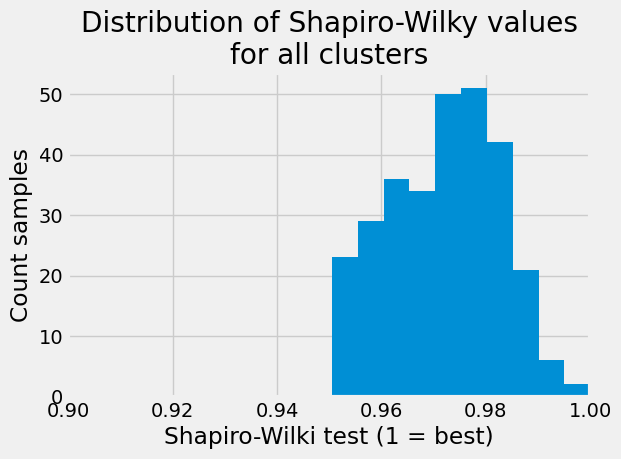

In [125]:
ax = df.groupby(['Cluster'])['Shapiro'].agg('mean')\
.plot(figsize=(6,4),kind='hist',bins=10, title='Distribution of Shapiro-Wilky values\nfor all clusters',xlim=[.9,1])
ax.set_xlabel("Shapiro-Wilki test (1 = best)")
ax.set_ylabel("Count samples")
print(f"Num Clusters {df['Cluster'].nunique()}, avarage Shapiro test: {df.groupby(['Cluster'])['Shapiro'].mean().mean()
}")

In [163]:
# df.groupby(['Cluster'])[['Shapiro']].agg(['count','mean'])\
# .sort_values(by=('Shapiro','mean'),ascending=False)[:15]

In [160]:
# df2 = df[df['Cluster']=='штамп-3']
# ax = df2['price_vat'].hist(figsize=(4,3))
# ax.set_xlabel("Price VAT, UAH")
# ax.set_ylabel("Count samples")
# print(f"Num Clusters {df2['Cluster'].nunique()}, avarage Shapiro test: {df2.groupby(['Cluster'])['Shapiro'].mean().mean()
# }")

In [161]:
# df2[['product_description_ukr','price_vat']]

Cluster папк-11, count:  61  Shapiro-wilki: 1.0
Папка "Data Bank " №MT-4302G A4  Standart на рез. черв.(1) ______Price: 48.0
Папка "Data Bank " №MT-4302G A4  Standart на рез. черв.(1) ______Price: 48.0
Папка "Data Bank " №MT-4302G A4 Standart на рез. черв.(1) ______Price: 48.0
Папка "Data Bank " №MT-4302G A4  Standart на рез. черв.(1) ______Price: 48.0
Папка "Data Bank " №MT-4302G A4  Standart на рез. черв.(1) ______Price: 48.0
Папка "Data Bank " №MT-4302G A4  Standart на рез. черв.(1 ______Price: 48.0
Папка "Data Bank " №MT-4302G A4  Standart на рез. черв.(1) ______Price: 48.0
Папка "Data Bank " №MT-4302G A4 Standart на рез. черв.(1) ______Price: 48.0
Папка "Data Bank " №MT-4302G A4  Standart на рез. черв.(1) ______Price: 48.0
Папка "Data Bank " №MT-4302G A4 Standart на рез. черв.(1) ______Price: 48.0
----------------------------------------------------------------------------------------------------


Cluster папк-28, count:  58  Shapiro-wilki: 1.0
Папка "CoolForSchool" №CF31642-02 В

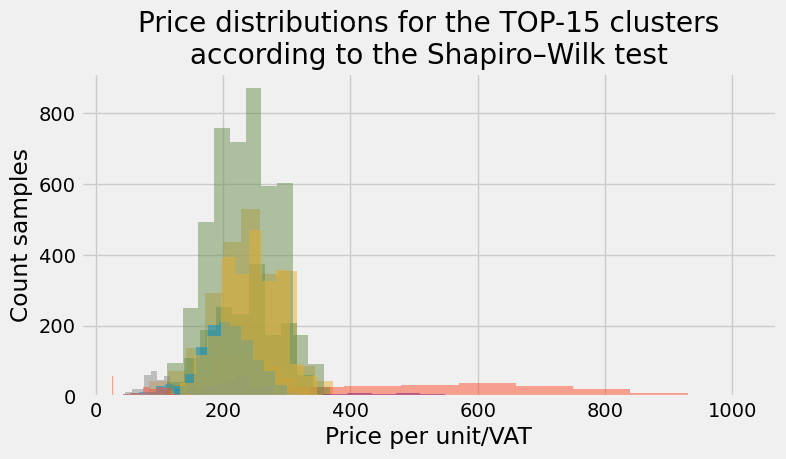

In [159]:
cluster = df.groupby(['Cluster'])['Shapiro'].agg(['count','mean'])\
.sort_values(by=('mean'),ascending=False)[:15].index

transactions_per_cluster = 10

fig, ax = plt.subplots(figsize=(8, 4))

for i in cluster:
    transactions = df[df['Cluster'] == i]\
        .sample(transactions_per_cluster, random_state=42)\
    
    print(f"Cluster {i}, count: ",df[df['Cluster'] == i].shape[0],' Shapiro-wilki:', df[df['Cluster'] == i].iloc[0]['Shapiro'])
    
    ax = df[df['Cluster'] == i]['price_vat'].plot(kind='hist',alpha=0.5,
                                              title='Price distributions for the TOP-15 clusters\naccording to the Shapiro–Wilk test')
    ax.set_xlabel("Price per unit/VAT")
    ax.set_ylabel("Count samples")
    # ax.title("Histogram of Ages")
    
    for index,d in transactions.iterrows():
        print(d['product_description_ukr'],'______Price:',d['price_vat'])

    print("-" * 100)
    print("\n")


df.to_csv('./3019/prozorro_scu_data_cpv3019.csv',index=False)

